In [334]:
import numpy as np
import matplotlib.pyplot as plt
from cross_diffusion_process import *
import torch
import pickle

In [335]:
K_X = torch.load('data/KernelData/K_X.pt')
K_Y = torch.load('data/KernelData/K_y.pt')

with open('data/KernelData/Z.pkl', 'rb') as f:
    Z = pickle.load(f)
    
K_X.shape, K_Y.shape

(torch.Size([5, 231, 231]), torch.Size([1, 231, 231]))

In [336]:
K_X = K_X[[0,1,3]]
K_X

tensor([[[0.0000, 0.0000, 0.1190,  ..., 0.0238, 0.0000, 0.0238],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.1190, 0.0000, 0.0000,  ..., 0.0714, 0.0000, 0.0000],
         ...,
         [0.0238, 0.0000, 0.0714,  ..., 0.0000, 0.0000, 0.1429],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0238, 0.0000, 0.0000,  ..., 0.1429, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.3333,  ..., 0.0000, 0.1667, 0.0714],
         [0.0000, 0.0000, 0.0238,  ..., 0.1429, 0.0000, 0.0238],
         [0.3333, 0.0238, 0.0000,  ..., 0.0000, 0.0476, 0.0952],
         ...,
         [0.0000, 0.1429, 0.0000,  ..., 0.0000, 0.0476, 0.2143],
         [0.1667, 0.0000, 0.0476,  ..., 0.0476, 0.0000, 0.2143],
         [0.0714, 0.0238, 0.0952,  ..., 0.2143, 0.2143, 0.0000]],

        [[0.0000, 0.7143, 0.2381,  ..., 0.0476, 0.0000, 0.1905],
         [0.7143, 0.0000, 0.2381,  ..., 0.0714, 0.0000, 0.1905],
         [0.2381, 0.2381, 0.0000,  ..., 0.1429, 0.0952, 0.

In [337]:
M,I,J = K_X.shape
M,I,J

(3, 231, 231)

In [338]:

X_ten = np.zeros((I, J, M))

for ii in range(M):
    X_ten[:, :, ii] = K_X[ii, :, :]


X_ten = X_ten.astype(float)
X_ten.shape

(231, 231, 3)

In [339]:
# Cross-diffusion process
kNN = 7
iter = 1
X_diffusion = cross_diffusion_process(X_ten, kNN, iter)

In [340]:
X_diffusion.shape

(231, 231, 3)

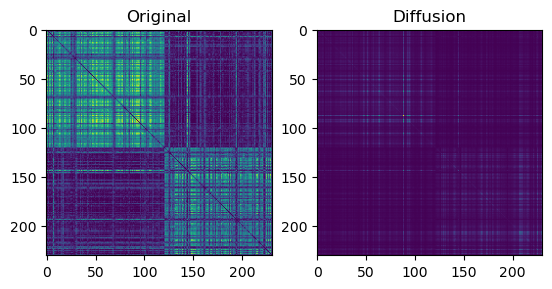

In [341]:
plt.figure(9)
plt.subplot(1, 2, 1)
plt.title('Original')
plt.imshow(X_ten[:,:,2], cmap='viridis')
plt.subplot(1, 2, 2)
plt.title('Diffusion')
plt.imshow(X_diffusion[:,:,2], cmap='viridis')
plt.show()

In [342]:
# %%writefile classify_kernel_AD.py
import numpy as np
from umap import UMAP
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='umap')

def classify_kernel_AD(outputs,y_train, PET_Z, verbose=False):

  umap = UMAP(n_components=10, random_state=42)

  X_umap = umap.fit_transform(outputs)
  y = y_train[0,0,:]
  Z_train, Z_val, Z_test = PET_Z[0], PET_Z[1],PET_Z[2]
  Z_train = np.concatenate([Z_train, Z_val], axis=0)
  X_train, X_test, y_train, y_test = X_umap[Z_train,:], X_umap[Z_test,:], y[Z_train], y[Z_test]


  # X_train, X_test, y_train, y_test =  train_test_split(X_umap,y, test_size=0.2, random_state=41)
  # Create a Random Forest classifier
  rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

  # Fit the model to the training data
  rf_classifier.fit(X_train, y_train)

  # Get the number of trees in the forest
  num_trees = len(rf_classifier.estimators_)



  # =================
  # Make predictions on the training data
  y_pred = rf_classifier.predict(X_train)

  # Evaluate the model
  accuracy = accuracy_score(y_train, y_pred)
  if verbose:
    print(f"Accuracy train: {accuracy:.2f}")

    # # Display the classification report
    # print("Classification Report train:")
    # print(classification_report(y_train, y_pred))


  # ==========================
  # Make predictions on the testing data
  y_pred = rf_classifier.predict(X_test)

  # Evaluate the model
  accuracy = accuracy_score(y_test, y_pred)
  conf_matrix = confusion_matrix(y_test, y_pred)

  if verbose:
    print(f"Accuracy test: {accuracy:.2f}")

    # # Display the classification report
    # print("Classification Report test:")
    # print(classification_report(y_test, y_pred))
  return confusion_matrix, accuracy



In [343]:

K_y = torch.load('data/KernelData/K_y.pt')

In [344]:
#random state 
np.random.seed(42)
# Mapping label 0,1,2,3,4 to CSF,GM,MRI,PET,SNP
label_mapping = {0: 'CSF', 1: 'GM', 2: 'PET'}


results = []
for modality in range(3):
    
    print(f"Modality {label_mapping[modality]} Before diffusion")
    K = X_ten[:,:,modality]
    Confusion_before, acc_before = classify_kernel_AD(K, K_y, Z, verbose=True)

    print(f"Modality {label_mapping[modality]} After diffusion")
    K = X_diffusion[:,:,modality]
    Confusion_after, acc_after = classify_kernel_AD(K, K_y, Z, verbose=True)

    results.insert(0, [acc_before, acc_after])


Modality CSF Before diffusion
Accuracy train: 1.00
Accuracy test: 0.77
Modality CSF After diffusion
Accuracy train: 1.00
Accuracy test: 0.74
Modality GM Before diffusion
Accuracy train: 1.00
Accuracy test: 0.70
Modality GM After diffusion
Accuracy train: 1.00
Accuracy test: 0.77
Modality PET Before diffusion
Accuracy train: 1.00
Accuracy test: 0.87
Modality PET After diffusion
Accuracy train: 1.00
Accuracy test: 0.89


In [345]:
results

[[0.8723404255319149, 0.8936170212765957],
 [0.7021276595744681, 0.7659574468085106],
 [0.7659574468085106, 0.7446808510638298]]

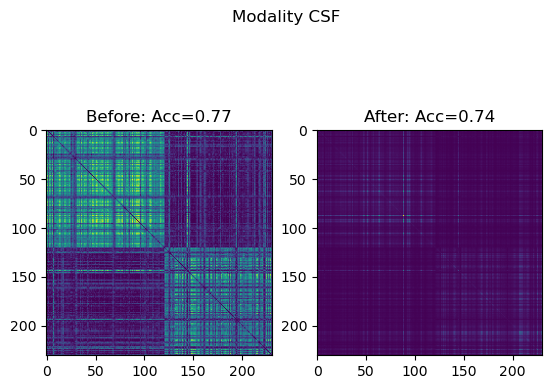

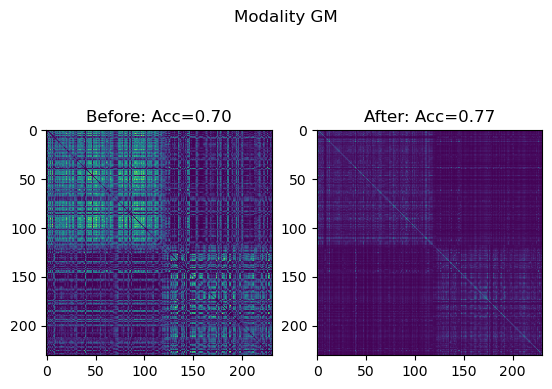

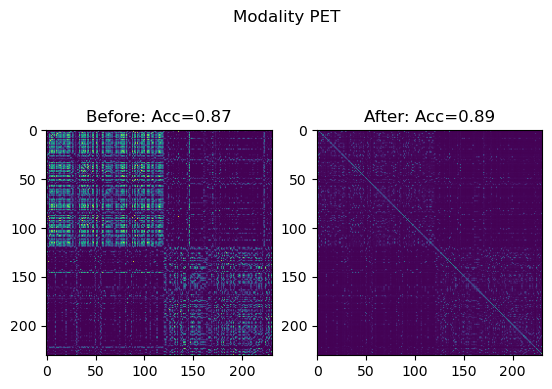

In [346]:
for i in range(2,-1,-1):
    modality = 2 - i 
    plt.figure(i)
    plt.subplot(1, 2, 1)
    plt.imshow(X_ten[:,:,i], cmap='viridis')
    plt.title(f"Before: Acc={results[i][0]:.2f}")
    plt.subplot(1, 2, 2)
    plt.imshow(X_diffusion[:,:,i], cmap='viridis')
    plt.title(f"After: Acc={results[i][1]:.2f}")
    plt.suptitle(f"Modality {label_mapping[modality]}")
    # plt.savefig(f'figures/{iter}_{kNN}_modality_{label_mapping[modality]}.png')  # Save the figure
    plt.show()

## Result of NGF

<Figure size 1000x500 with 0 Axes>

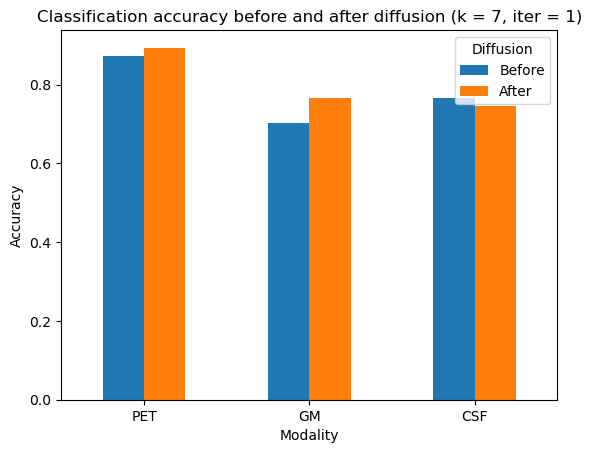

In [347]:
# Visualize results and save figures
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

results = np.array(results)
plt.figure(figsize=(10, 5))
df = pd.DataFrame(results, columns=['Before', 'After'], index=['PET', 'GM', 'CSF'])
df.plot(kind='bar', title=f'Classification accuracy before and after diffusion (k = {kNN}, iter = {iter})')
plt.ylabel('Accuracy')
plt.xlabel('Modality')
plt.xticks(rotation=0)
plt.legend(title='Diffusion')

# Save figure before showing the plot
# plt.savefig(f'figures/single_modality_fusion_{iter}_{kNN}.png')

plt.show()  # This should be the last command

# Save results
# df.to_csv(f'results/single_modality_fusion_{iter}_{kNN}.csv')

In [348]:
X_ten.shape

(231, 231, 3)

In [349]:
# Ksum = np.sum(X_ten.astype(float), axis=2)
# Confusion_Ksum, acc_Ksum = classify_kernel_AD(Ksum, K_y, Z)

